# 04. Identifying Fraudulent Activities 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

%matplotlib inline

In [1]:
from platform import python_version
print(python_version())

3.6.10


In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px solid lightgray;
}

## Load Dataset

In [14]:
data = pd.read_csv('E:/Collection_DS_takehome_challenges/Data/Fraud_Data.csv')
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   user_id         151112 non-null  int64 
 1   signup_time     151112 non-null  object
 2   purchase_time   151112 non-null  object
 3   purchase_value  151112 non-null  int64 
 4   device_id       151112 non-null  object
 5   source          151112 non-null  object
 6   browser         151112 non-null  object
 7   sex             151112 non-null  object
 8   age             151112 non-null  int64 
 9   ip_address      151112 non-null  int32 
 10  class           151112 non-null  int64 
dtypes: int32(1), int64(4), object(6)
memory usage: 12.1+ MB


In [9]:
data.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [27]:
ipaddress = pd.read_csv('E:/Collection_DS_takehome_challenges/Data/IpAddress_to_Country.csv')
ipaddress.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [10]:
ipaddress.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [30]:
ipaddress['lower_bound_ip_address']=ipaddress['lower_bound_ip_address'].astype(np.int64)

In [31]:
ipaddress.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216,16777471,Australia
1,16777472,16777727,China
2,16777728,16778239,China
3,16778240,16779263,Australia
4,16779264,16781311,China


In [32]:
ipaddress.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   lower_bound_ip_address  138846 non-null  int64 
 1   upper_bound_ip_address  138846 non-null  int64 
 2   country                 138846 non-null  object
dtypes: int64(2), object(1)
memory usage: 3.2+ MB


## Merge Country to Fraud Data

In [35]:
countries = []
for i in range(len(data)):
    ip_address = data.loc[i, 'ip_address']
    tmp = ipaddress[(ipaddress['lower_bound_ip_address'] <= ip_address) &
                    (ipaddress['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('NA')
        
data['country'] = countries


In [34]:
data.head(10)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [37]:
#from pandasql import sqldf
#pysqldf = lambda q: sqldf(q, globals())

In [38]:
#q = """
#   SELECT A.*,B.country
#        FROM
#            data A
#        left JOIN
#            ipaddress B
#        ON 
#           A.ip_address <= B.upper_bound_ip_address AND
#            A.ip_address >= B.lower_bound_ip_address;
#    """

#data1 = pysqldf(q)

In [39]:
#data1.head(10)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,None
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,United States
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada,Canada
6,50116,2015-08-01 22:40:52,2015-08-27 03:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,0,NA,None
7,360585,2015-04-06 07:35:45,2015-05-25 17:21:14,27,HPUCUYLMJBYFW,Ads,Opera,M,34,1.692459e+09,0,United States,United States
8,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0,China,China
9,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,0,United States,United States


## Feature Engineering

1. Time difference between sign-up time and purchase time
2. If the device id is unique or certain users are sharing the same device (many different user ids using the same device could be an indicator of fake accounts)
3. Same for the ip address. Many different users having the same ip address could be an indicator of fake accounts
4. Usual week of the year and day of the week from time variables

In [41]:
# Get the time difference between purchase time and signup time
data['purchase_time'] = pd.to_datetime(data['purchase_time'])
data['signup_time'] = pd.to_datetime(data['signup_time'])
time_diff=data['purchase_time']-data['signup_time']
time_diff=time_diff.apply(lambda x :x.seconds)
data['time_diff']=time_diff

In [42]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461


In [45]:
# Get different user number for each unique devices
device_num=data[['user_id','device_id']].groupby('device_id').count().reset_index()
device_num=device_num.rename(columns={'user_id':'users_for_same_device'})
data=data.merge(device_num,how='left',on='device_id')

In [46]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,users_for_same_device
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1


In [48]:
# Get different user number for each unique ip_address
ip_num=data[['user_id','ip_address']].groupby('ip_address').count().reset_index()
ip_num=ip_num.rename(columns={'user_id':'users_for_same_ip'})
data=data.merge(ip_num,how='left',on='ip_address')

In [49]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,users_for_same_device,users_for_same_ip
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,1


In [ ]:
## Signup day and week
data['signup_day'] = data['signup_time'].apply(lambda x: x.dayofweek)
data['signup_week'] = data['signup_time'].apply(lambda x: x.week)

# Purchase day and week
data['purchase_day'] = data['purchase_time'].apply(lambda x: x.dayofweek)
data['purchase_week'] = data['purchase_time'].apply(lambda x: x.week)

In [51]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,users_for_same_device,users_for_same_ip,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1,1,9,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1,6,23,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12,3,1,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1,1,1,18,0,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,1,1,30,2,37


In [55]:
# Define features and target to be used
columns = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', 
           'browser', 'sex', 'age', 'country', 'time_diff', 'users_for_same_device', 'users_for_same_ip', 'class']
data = data[columns]
data.head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,users_for_same_device,users_for_same_ip,class
0,1,9,5,16,34,SEO,Chrome,M,39,Japan,13882,1,1,0
1,6,23,0,24,16,Ads,Chrome,F,53,United States,17944,1,1,0
2,3,1,3,1,15,SEO,Opera,M,53,United States,1,12,12,1
3,1,18,0,19,44,SEO,Safari,M,41,NA,60085,1,1,0
4,1,30,2,37,39,Ads,Safari,M,45,United States,41461,1,1,0


## Fraudulent Activity Identification

In [52]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.162-b12, mixed mode)
  Starting server from D:\Anaconda3\envs\py36\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\DELL\AppData\Local\Temp\tmpiuzep623
  JVM stdout: C:\Users\DELL\AppData\Local\Temp\tmpiuzep623\h2o_ALEX_started_from_python.out
  JVM stderr: C:\Users\DELL\AppData\Local\Temp\tmpiuzep623\h2o_ALEX_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,08 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.4
H2O_cluster_version_age:,5 months and 4 days !!!
H2O_cluster_name:,H2O_from_python_ALEX_dw9e8m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.752 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [56]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(data)

for name in ['signup_day', 'purchase_day', 'source', 'browser', 'sex', 'country', 'class']:
    h2o_df[name] = h2o_df[name].asfactor()

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,users_for_same_device,users_for_same_ip,class
type,enum,int,enum,int,int,enum,enum,enum,int,enum,int,int,int,enum
mins,,1.0,,1.0,9.0,,,,18.0,,1.0,1.0,1.0,
mean,,16.501740430938636,,24.658571126052156,36.93537243898569,,,,33.14070358409651,,40942.58442744467,1.684366562549631,1.6027185134205102,
maxs,,34.0,,51.0,154.0,,,,76.0,,86399.0,20.0,20.0,
sigma,,9.814287461798882,,11.651556782719437,18.322762148662125,,,,8.61773349096148,,26049.661902118398,2.616953602804182,2.5962395273758387,
zeros,,0,,0,0,,,,0,,0,0,0,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1,9.0,5,16.0,34.0,SEO,Chrome,M,39.0,Japan,13882.0,1.0,1.0,0
1,6,23.0,0,24.0,16.0,Ads,Chrome,F,53.0,United States,17944.0,1.0,1.0,0
2,3,1.0,3,1.0,15.0,SEO,Opera,M,53.0,United States,1.0,12.0,12.0,1


In [59]:
# Split into 75% training and 25% test dataset
strat_split=h2o_df['class'].stratified_split(test_frac=0.25,seed=42)

train=h2o_df[strat_split=='train']
test=h2o_df[strat_split=='test']

# Define features and target
feature=['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', 
           'browser', 'sex', 'age', 'country', 'time_diff', 'users_for_same_device', 'users_for_same_ip']
target='class'

In [60]:
model=H2ORandomForestEstimator(balance_classes=True,ntrees=100,max_depth=20,mtries=-1,seed=42,
                              stopping_rounds=5,stopping_metric='auc',score_each_iteration=True)
model.train(x=feature,y=target,training_frame=train,validation_frame=test)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [61]:
model.score_history()

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-11-06 10:09:32,0.074 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2020-11-06 10:09:33,1.422 sec,1.0,0.327647,0.783649,0.956796,0.943932,1.927384,0.101562,0.257544,1.718039,0.786098,0.485754,7.244746,0.065408
2,,2020-11-06 10:09:34,2.087 sec,2.0,0.336229,0.685408,0.956275,0.948226,1.943824,0.101522,0.210589,0.598370,0.809881,0.651674,10.196517,0.045026
3,,2020-11-06 10:09:35,2.834 sec,3.0,0.336878,0.591676,0.962871,0.956620,1.956914,0.093620,0.204783,0.398368,0.825708,0.680300,10.561239,0.043994
4,,2020-11-06 10:09:35,3.202 sec,4.0,0.337555,0.540227,0.966234,0.961611,1.965271,0.089523,0.203144,0.327178,0.828633,0.688376,10.627364,0.043676
5,,2020-11-06 10:09:35,3.597 sec,5.0,0.326591,0.479671,0.974236,0.969413,1.970582,0.075548,0.202847,0.301508,0.830825,0.694085,10.666509,0.043729
6,,2020-11-06 10:09:36,4.049 sec,6.0,0.324215,0.441024,0.977677,0.973823,1.976162,0.070579,0.202614,0.275659,0.832492,0.695070,10.666509,0.043570
7,,2020-11-06 10:09:36,4.554 sec,7.0,0.328029,0.413902,0.979819,0.977138,1.982002,0.068642,0.202188,0.256518,0.834151,0.699003,10.677784,0.044338
8,,2020-11-06 10:09:37,5.035 sec,8.0,0.329465,0.390618,0.982118,0.980281,1.986525,0.067495,0.202104,0.242387,0.834679,0.700118,10.677784,0.043570
9,,2020-11-06 10:09:37,5.482 sec,9.0,0.329643,0.371126,0.984647,0.983285,1.989852,0.062335,0.202038,0.228457,0.836268,0.702304,10.677784,0.043570


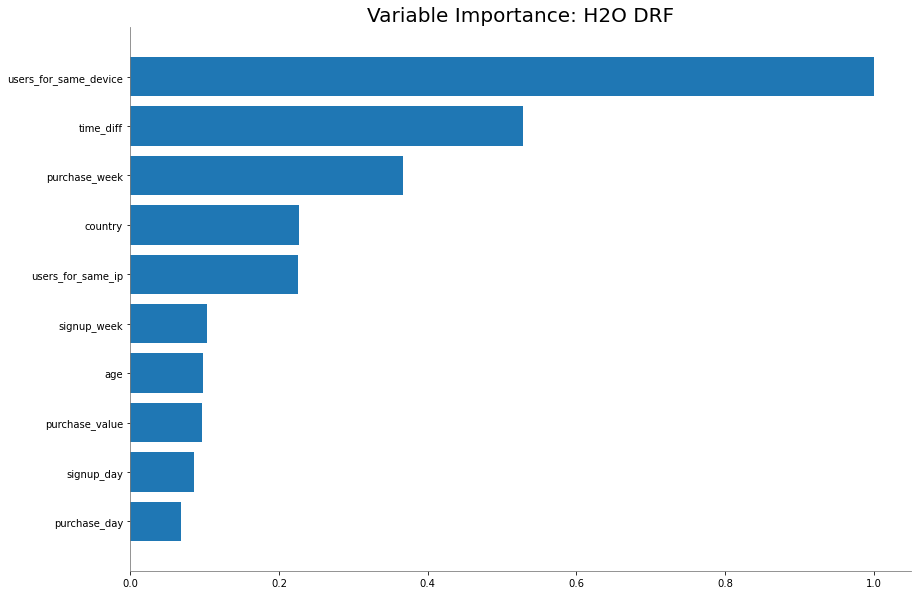

In [64]:
model.varimp_plot()

                 variable  relative_importance  scaled_importance  percentage
0   users_for_same_device        255620.234375           1.000000    0.344756
1               time_diff        134910.343750           0.527776    0.181954
2           purchase_week         93773.164062           0.366846    0.126472
3                 country         58088.617188           0.227246    0.078344
4       users_for_same_ip         57858.832031           0.226347    0.078034
5             signup_week         26356.402344           0.103108    0.035547
6                     age         24984.175781           0.097739    0.033696
7          purchase_value         24869.152344           0.097289    0.033541
8              signup_day         21841.550781           0.085445    0.029458
9            purchase_day         17465.373047           0.068325    0.023556
10                browser         14211.945312           0.055598    0.019168
11                 source          7223.234375           0.02825

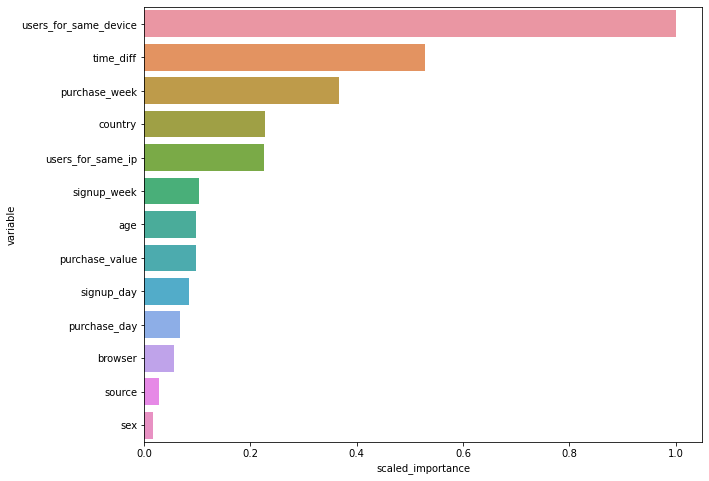

In [65]:
# Feature importance
importance = model.varimp(use_pandas=True)
print(importance)
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

In [66]:
# Make predictions
train_true=train.as_data_frame()['class'].values # remove index, only keep values as array 
print(train_true)
test_true=test.as_data_frame()['class'].values
train_pred=model.predict(train).as_data_frame()['p1'].values # have 3 columns: predict,p0,p1
test_pred=model.predict(test).as_data_frame()['p1'].values # have 3 columns: predict,p0,p1

train_fpr,train_tpr,_=roc_curve(train_true,train_pred)
test_fpr,test_tpr,_=roc_curve(test_true,test_pred)
train_auc=np.round(auc(train_fpr,train_tpr),3)
test_auc=np.round(auc(test_fpr,test_tpr),3)

[0 0 1 ... 0 0 0]
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [67]:
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     34240
           1       1.00      0.53      0.70      3538

    accuracy                           0.96     37778
   macro avg       0.98      0.77      0.84     37778
weighted avg       0.96      0.96      0.95     37778



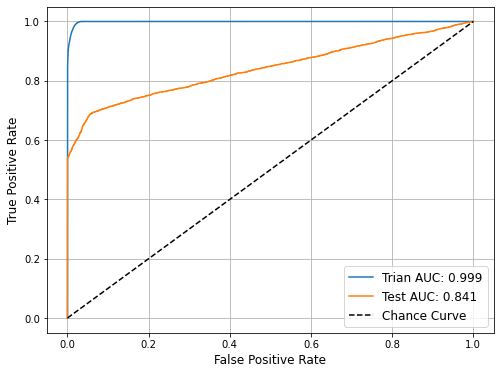

In [69]:
train_fpr = np.insert(train_fpr, 0, 0)
train_tpr = np.insert(train_tpr, 0, 0)
test_fpr = np.insert(test_fpr, 0, 0)
test_tpr = np.insert(test_tpr, 0, 0)

fig,ax=plt.subplots(figsize=(8,6))
ax.plot(train_fpr,train_tpr,label='Trian AUC: '+str(train_auc))
ax.plot(test_fpr,test_tpr,label='Test AUC: '+str(test_auc))
ax.plot(train_fpr, train_fpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.grid(True)
ax.legend(fontsize=12)
plt.show()

Based on the ROC, if we care about minimizing false positive, we would choose a cut-off that would give us true positive rate of ~0.5 and false positive rate almost zero (this was essentially the random forest output). However, if we care about maximizing true positive, we will have to decrease the cut-off. This way we will classify more events as “1”: some will be true ones (so true positive goes up) and many, unfortunately, will be false ones (so false positive will also go up).

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


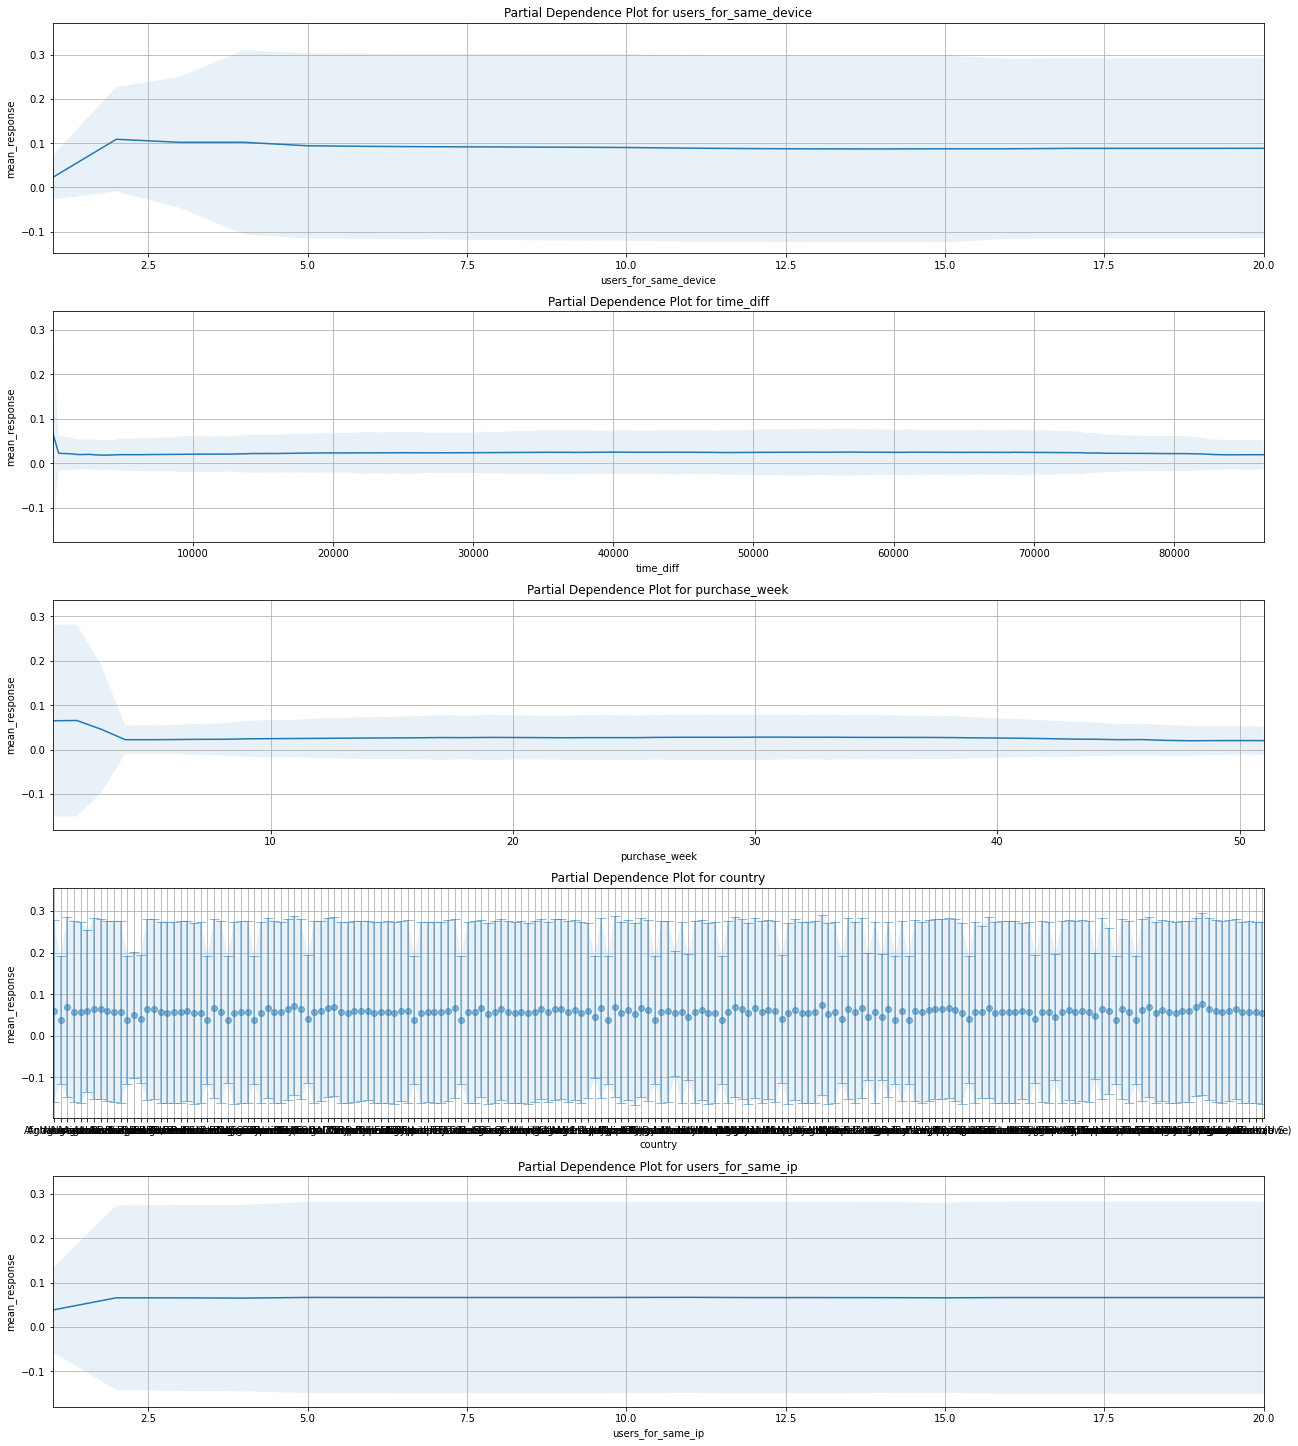

In [75]:
cols = ['users_for_same_device', 'time_diff', 'purchase_week', 'country', 'users_for_same_ip']
_ = model.partial_plot(train, cols=cols,nbins=200, figsize=(18, 20))

In [76]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_80ca closed.


Regarding “how to use this from a product perspective”: you now have a model that assigns to each user a probability of committing a fraud. You want to think about creating different experiences based on that. For instance:

1. If predicted fraud probability < X, the user has the normal experience (the high majority should fall here)
2. If X <= predicted fraud probability < Z (so the user is at risk, but not too much), you can create an additional verification step, like verify your phone number via a code sent by SMS or log in via Facebook.
3. If predicted fraud probability >= Z (so here is really likely the user is trying to commit a fraud), you can tell the user his session has been put on hold, send this user info to someone who reviews it manually and either blocks the user or decides it is not a fraud so the session is resumed.

This is just an example and there are many different ways to build products around some fraud score. However, it is important because it highlights that a ML model is often really useful when it is combined with a product which is able to take advantage of its strengths and minimize its possible drawbacks (like false positives).